In [213]:
import os

import pandas as pd
import numpy as np
import geopandas as gpd 
import rasterio 
from rasterio.plot import  show, adjust_band
import seaborn as sns 
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [214]:
from visualisation_scripts import get_maps

In [215]:
archangelskiy = pd.read_csv('points_gps/arch_crc.csv', encoding=  'ANSI', sep = ';')
archangelskiy['вес'] =archangelskiy['вес'] - archangelskiy['тара']
archangelskiy['вес [ц/на]'] = archangelskiy['вес'] * 4 * (10000) / 1000 / 100
archangelskiy = archangelskiy[['точка', '%', 'вес [ц/на]']]
archangelskiy = archangelskiy.groupby('точка').mean().reset_index()
archangelskiy.columns = ['type', 'perc [%]',"вес [ц/на]" ]
archangelskiy

,type,perc [%],вес [ц/на]
0,525,62.50,21.4
1,526,81.25,41.5
2,527,68.75,32.5
3,528,68.75,24.0
4,586,96.75,62.4
5,587,43.75,38.9
6,588,33.75,27.4


In [216]:
archangelskiy_points = gpd.read_file('points_gps/arch_points.geojson')[['name', 'geometry']]
archangelskiy_points.columns = ['type',"geometry" ]
archangelskiy_points.head(5)

,type,geometry
0,525,POINT Z (44.18418 44.55136 170.78041)
1,526,POINT Z (44.18086 44.54805 167.81140)
2,527,POINT Z (44.17407 44.54223 164.98230)
3,528,POINT Z (44.16865 44.54459 169.67947)
4,529,POINT Z (44.16700 44.53811 175.87118)


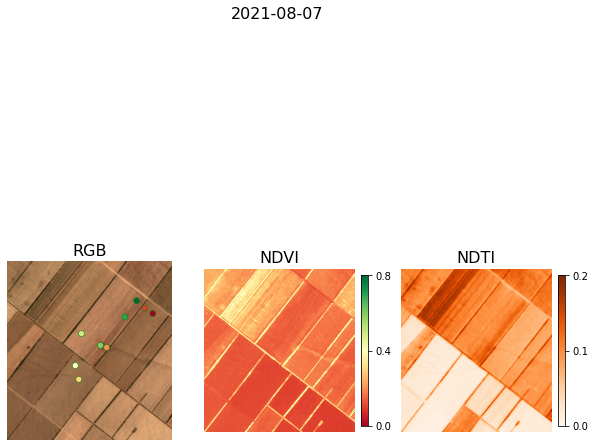

In [362]:
raster_list = os.listdir('raster_data')
raster_dir ='raster_data/' + raster_list[2]


fig  = get_maps(raster_list[2],archangelskiy_points , 'sen-2')


raster = rasterio.open(raster_dir)
meta_data = raster.meta

NDTI = raster.read()[7]
NDVI = raster.read()[6]


In [363]:
NDVI_to_vis = NDVI.copy()
NDVI_to_vis[NDVI_to_vis <= 0.25] = np.nan

NDTI_to_vis = NDTI.copy()
NDTI_to_vis[(NDVI_to_vis >= 0.25)] = np.nan

In [364]:
NDTI_to_vis

array([[       nan,        nan,        nan, ..., 0.10104727, 0.09816735,
        0.09816735],
       [       nan,        nan,        nan, ..., 0.10104727, 0.09816735,
        0.09816735],
       [       nan,        nan,        nan, ..., 0.09938237, 0.09808882,
        0.09808882],
       ...,
       [0.05617978,        nan,        nan, ..., 0.01800875, 0.01905873,
        0.01905873],
       [       nan,        nan,        nan, ..., 0.01800875, 0.01905873,
        0.01905873],
       [       nan,        nan,        nan, ..., 0.02099163, 0.02150259,
        0.02150259]], dtype=float32)

(-0.5, 368.5, 400.5, -0.5)

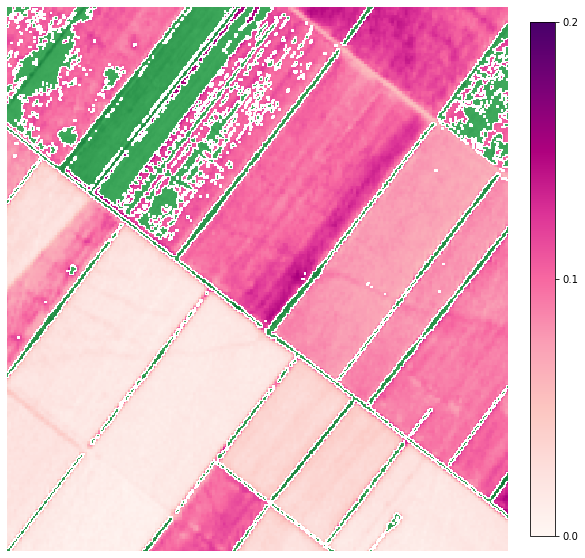

In [365]:
fig, axes = plt.subplots(1,1, figsize=(10,10)) 
NDVI_hiden = axes.imshow(NDVI_to_vis, cmap='Greens')
NDVI_hiden.set_clim(vmin = -1 , vmax = 1)
NDTI_vis = axes.imshow(NDTI_to_vis, cmap='RdPu')

fig.colorbar(NDTI_vis,fraction=0.046, pad=0.04, ax=axes).set_ticks([ 0,0.1,0.2])
NDTI_vis.set_clim(vmin = 0 , vmax = 0.2)
axes.axis('off')

In [366]:
NDTI[NDVI > 0.3] = np.nan # маска по NDVI
NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)] #удаление пропусков 
top = NDTI_arr.mean() + (3 * NDTI_arr.std())
bottom = NDTI_arr.mean() - (3 * NDTI_arr.std())
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)
def RC_cover(x):
    rc = (m * x) + b 
    return(rc)
imperic_crc = RC_cover(NDTI)

In [367]:
np.nanmax(imperic_crc)

0.9780028

надо отвизуализировать NDTI


(-0.5, 368.5, 400.5, -0.5)

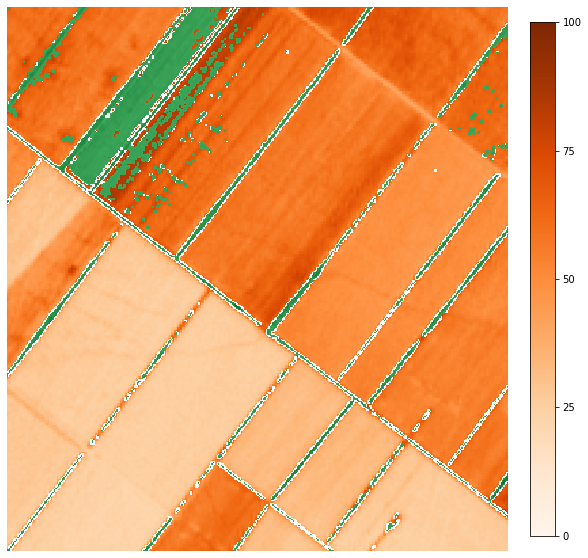

In [368]:
fig, axes = plt.subplots(1,1, figsize=(10,10)) 
NDVI_hiden = axes.imshow(NDVI_to_vis, cmap='Greens')
NDVI_hiden.set_clim(vmin = -1 , vmax = 1)

NDTI_vis = axes.imshow((imperic_crc * 100), cmap='Oranges')

fig.colorbar(NDTI_vis,fraction=0.046, pad=0.04, ax=axes).set_ticks([ 0,25,50,75,100])
NDTI_vis.set_clim(vmin = 0 , vmax = 100)
axes.axis('off')

In [317]:
NDVI[NDVI > 0.3]

array([0.37886414, 0.40164202, 0.32297447, ..., 0.3631952 , 0.36479843,
       0.3813814 ], dtype=float32)

In [182]:
X_ = archangelskiy_points.to_crs(meta_data['crs']).geometry.x
Y_ = archangelskiy_points.to_crs(meta_data['crs']).geometry.y

NDTI_points_dict ={}

for i in range(len(archangelskiy_points['type'])):
    ind =  (raster.index(X_[i],Y_[i]))
    NDTI_points_dict[archangelskiy_points['type'][i]] = NDTI[ind[0], ind[1]]
NDTI_values = pd.DataFrame.from_dict(NDTI_points_dict, orient='index',).reset_index()
NDTI_values.columns = ['type', 'NDTI_value']

NDTI_values


,type,NDTI_value
0,525,0.102655
1,526,0.100361
2,527,0.099514
3,528,0.082840
4,529,0.100719
5,585,0.094620
6,586,0.116338
7,587,0.257286
8,588,0.238180


In [183]:
archangelskiy['type'] = archangelskiy['type'].astype('int')
NDTI_values['type'] = NDTI_values['type'].astype('int')

In [184]:
NDTI_DF = archangelskiy.merge(NDTI_values, on = 'type', how = 'outer')
NDTI_DF = NDTI_DF.fillna(value = 0)
NDTI_DF

,type,perc [%],вес [ц/на],NDTI_value
0,525,62.50,21.4,0.102655
1,526,81.25,41.5,0.100361
2,527,68.75,32.5,0.099514
3,528,68.75,24.0,0.082840
4,586,96.75,62.4,0.116338
5,587,43.75,38.9,0.257286
6,588,33.75,27.4,0.238180
7,529,0.00,0.0,0.100719
8,585,0.00,0.0,0.094620


теперь нужно имерически пересчитать данные на основании импирического коэфициента 

In [185]:
NDTI[NDVI > 0.3] = np.nan # маска по NDVI
NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)] #удаление пропусков 
top = NDTI_arr.max()
bottom = NDTI_arr.min() 
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)
def RC_cover(x):
    rc = (m * x) + b 
    return(rc)
imperic_crc = RC_cover(NDTI)


In [186]:
imperic_crc_points_dict ={}

for i in range(len(archangelskiy_points['type'])):
    ind =  (raster.index(X_[i],Y_[i]))
    imperic_crc_points_dict[archangelskiy_points['type'][i]] = imperic_crc[ind[0], ind[1]]
CRC_values = pd.DataFrame.from_dict(imperic_crc_points_dict, orient='index',).reset_index()
CRC_values.columns = ['type', 'CRC']

In [187]:
CRC_values['type'] = CRC_values['type'].astype('int')

NDTI_DF = NDTI_DF.merge(CRC_values, on = 'type', how = 'outer')

In [188]:
NDTI_DF

,type,perc [%],вес [ц/на],NDTI_value,CRC
0,525,62.50,21.4,0.102655,0.450502
1,526,81.25,41.5,0.100361,0.438752
2,527,68.75,32.5,0.099514,0.434413
3,528,68.75,24.0,0.082840,0.349014
4,586,96.75,62.4,0.116338,0.520584
5,587,43.75,38.9,0.257286,NaN
6,588,33.75,27.4,0.238180,NaN
7,529,0.00,0.0,0.100719,0.440588
8,585,0.00,0.0,0.094620,0.409346


In [189]:
CRC_values

,type,CRC
0,525,0.450502
1,526,0.438752
2,527,0.434413
3,528,0.349014
4,529,0.440588
5,585,0.409346
6,586,0.520584
7,587,NaN
8,588,NaN


0.0